# Assciation Rule Mining

Association Rule Mining is a technique used to discover interesting relationships (associations) or patterns among a large set of items in transaction databases, relational databases, or other information repositories.

In a supermarket, we might want to discover patterns like:

“*If a customer buys bread and butter, they are likely to also buy milk.*”

This helps in:

- Market basket analysis

- Recommendation systems

- Cross-selling strategies

- Inventory management

Let's explore some of the Association Rule Mining Algorithms

## Import 

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

In [6]:
sns.set_style('whitegrid')

## Read Data

In [8]:
df = pd.read_csv('strong_association_transactions.csv')
df.head()

,Transaction
0,"Milk, Eggs, Bread, Butter, Cheese"
1,"Yogurt, Milk, Cereal, Bread, Butter"
2,"Yogurt, Milk, Eggs, Fruits, Bread, Butter, Cheese"
3,"Eggs, Milk, Bread"
4,"Butter, Milk, Bread"


In [9]:
df.shape

(1000, 1)

In [10]:
df.isnull().sum()

Transaction    16
dtype: int64

It seems there are 16 null transactions

In [12]:
te = TransactionEncoder()
transactions = [str(row).split(', ') for row in df['Transaction'] if pd.notnull(row)] # consider only non-null values

te_array = te.fit(transactions).transform(transactions)
processed_df = pd.DataFrame(te_array, columns = te.columns_)

processed_df.head()

,Bread,Butter,Cereal,Cheese,Coffee,Eggs,Fruits,Juice,Milk,Yogurt
0,True,True,False,True,False,True,False,False,True,False
1,True,True,True,False,False,False,False,False,True,True
2,True,True,False,True,False,True,True,False,True,True
3,True,False,False,False,False,True,False,False,True,False
4,True,True,False,False,False,False,False,False,True,False


In [13]:
processed_df.to_csv('processed_transactions.csv', index=False)

In [14]:
processed_df.shape

(984, 10)

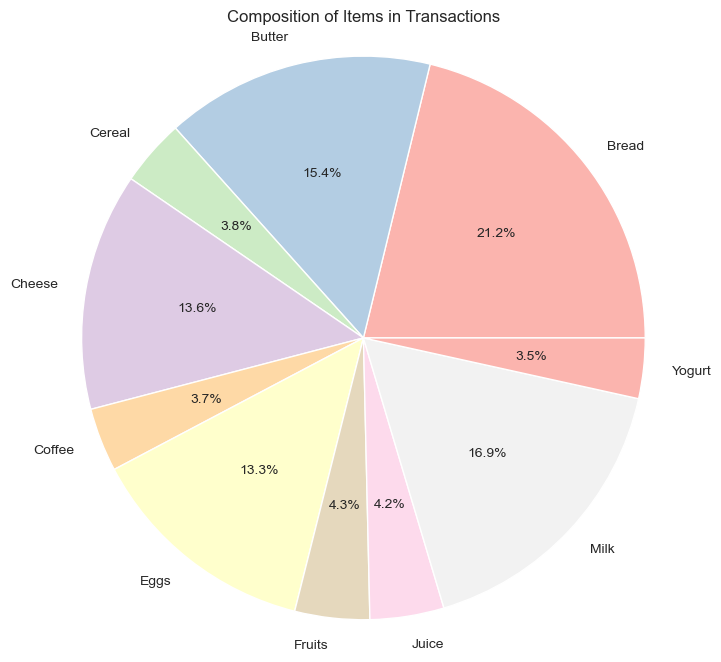

In [15]:
item_counts = processed_df.sum()

plt.figure(figsize=(8, 8))
plt.pie(item_counts, labels=item_counts.index, autopct='%1.1f%%', colors=plt.cm.Pastel1.colors)
plt.title('Composition of Items in Transactions')
plt.axis('equal')
plt.show()

Above pie-chart shows the composition of each items in the dataset of transactions.

## Apriori Algorithm

The Apriori algorithm is used to find frequent itemsets in a dataset and derive association rules from them.
It uses a bottom-up approach, where:

1. Frequent individual items are identified.

2. These are extended step-by-step to larger and larger itemsets (e.g., 2-itemsets, 3-itemsets).

3. It prunes (removes) itemsets that don’t meet the minimum support because if an itemset is not frequent, none of its supersets can be.

### Frequent-Itemset Generation

Minimum Support: 40%

In [20]:
frequent_itemsets = apriori(processed_df, verbose = 3, min_support = 0.4, use_colnames = True)
frequent_itemsets

Processing 4 combinations | Sampling itemset size 43


,support,itemsets
0,0.908537,(Bread)
1,0.661585,(Butter)
2,0.584350,(Cheese)
3,0.572154,(Eggs)
4,0.725610,(Milk)
5,0.642276,"(Bread, Butter)"
6,0.519309,"(Cheese, Bread)"
7,0.507114,"(Eggs, Bread)"
8,0.716463,"(Milk, Bread)"
9,0.464431,"(Milk, Butter)"


### Rule Generation

Threshold Confidence: 75%

In [22]:
rules = association_rules(frequent_itemsets, metric = 'confidence', min_threshold = 0.75)

In [23]:
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Butter),(Bread),0.661585,0.908537,0.642276,0.970814,1.068547,1.0,0.041202,3.133825,0.189560,0.692223,0.680901,0.838875
1,(Cheese),(Bread),0.584350,0.908537,0.519309,0.888696,0.978162,1.0,-0.011594,0.821742,-0.050975,0.533403,-0.216928,0.730142
2,(Eggs),(Bread),0.572154,0.908537,0.507114,0.886323,0.975550,1.0,-0.012709,0.804592,-0.055336,0.520877,-0.242866,0.722244
3,(Milk),(Bread),0.725610,0.908537,0.716463,0.987395,1.086797,1.0,0.057220,7.256098,0.291064,0.780731,0.862185,0.887993
4,(Bread),(Milk),0.908537,0.725610,0.716463,0.788591,1.086797,1.0,0.057220,1.297909,0.873191,0.780731,0.229530,0.887993


In [24]:
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

### Plot of Support vs. Confidence

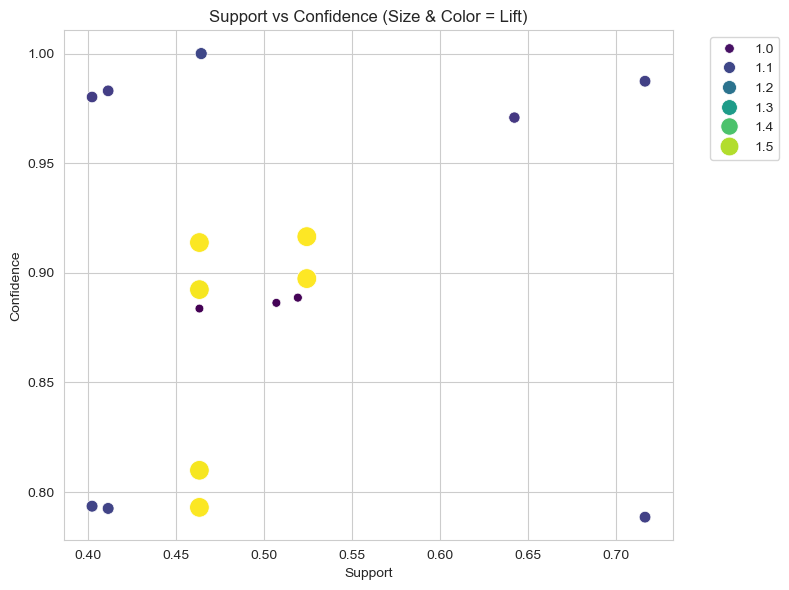

In [26]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rules, x="support", y="confidence", hue="lift", size="lift", palette="viridis", sizes=(40, 200))
plt.title("Support vs Confidence (Size & Color = Lift)")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Plot of Lifts of Asscociation Rules

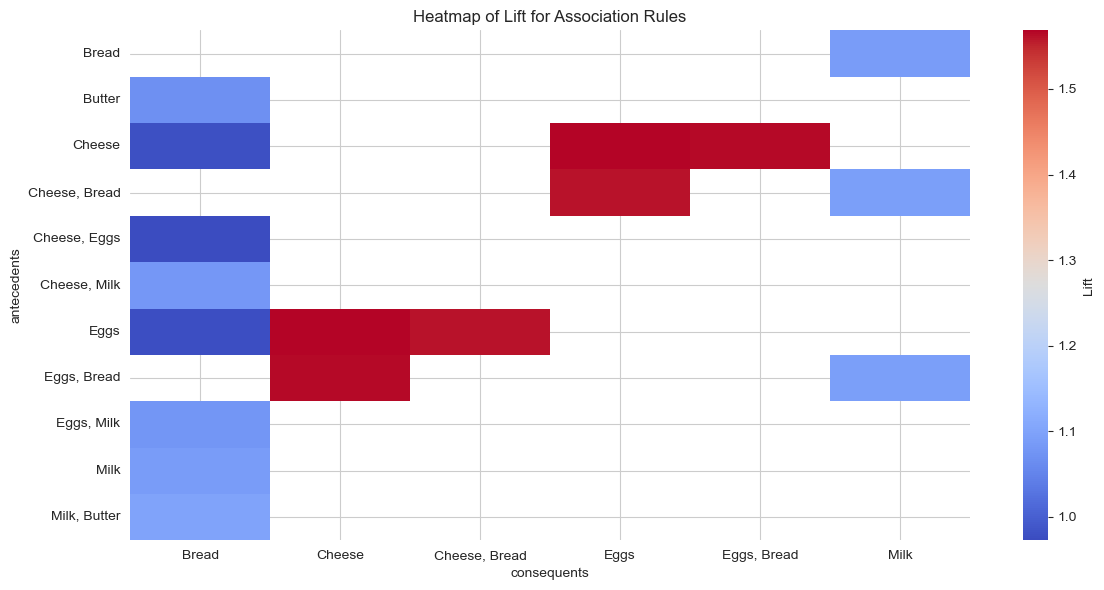

In [28]:
pivot = rules.pivot(index="antecedents", columns="consequents", values="lift")
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Lift'})
plt.title("Heatmap of Lift for Association Rules")
plt.tight_layout()
plt.show()

## FP-Growth Algorithm

The FP-Growth (Frequent Pattern Growth) algorithm is a highly efficient and scalable method for mining frequent itemsets without the need for candidate generation (unlike the Apriori algorithm). It's especially useful for large datasets.

The FP-Growth algorithm operates in two main phases:

1. Build an FP-Tree (Frequent Pattern Tree)

2. Mine the FP-Tree recursively to find all frequent itemsets

### Frequent-Itemset Generation

Minimum Support: 40%

In [32]:
freq_itemsets = fpgrowth(processed_df, min_support = 0.4, use_colnames = True)
freq_itemsets

,support,itemsets
0,0.908537,(Bread)
1,0.725610,(Milk)
2,0.661585,(Butter)
3,0.584350,(Cheese)
4,0.572154,(Eggs)
5,0.716463,"(Milk, Bread)"
6,0.642276,"(Bread, Butter)"
7,0.464431,"(Milk, Butter)"
8,0.464431,"(Milk, Bread, Butter)"
9,0.519309,"(Cheese, Bread)"


As we have obtained, the 2 algorithms generate identical frequent itemsets. The algorithms work in different ways to generate the frequent itemsets. So, the rules generated will be identical. 

### Rules

Threshold Confidence: 75%

In [35]:
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,Butter,Bread,0.661585,0.908537,0.642276,0.970814,1.068547,1.0,0.041202,3.133825,0.189560,0.692223,0.680901,0.838875
1,Cheese,Bread,0.584350,0.908537,0.519309,0.888696,0.978162,1.0,-0.011594,0.821742,-0.050975,0.533403,-0.216928,0.730142
2,Eggs,Bread,0.572154,0.908537,0.507114,0.886323,0.975550,1.0,-0.012709,0.804592,-0.055336,0.520877,-0.242866,0.722244
3,Milk,Bread,0.725610,0.908537,0.716463,0.987395,1.086797,1.0,0.057220,7.256098,0.291064,0.780731,0.862185,0.887993
4,Bread,Milk,0.908537,0.725610,0.716463,0.788591,1.086797,1.0,0.057220,1.297909,0.873191,0.780731,0.229530,0.887993


Let's use some threshold values for each metric to rank them based on the number of thresholds each crosses.

### Ranking Rules

In [38]:
# thresholds for rule ranking
thresholds = {
    'support': 0.4,
    'confidence': 0.75,
    'lift': 1.5,
    'representativity': 0.7,
    'leverage': 0.01,
    'conviction': 1.0,
    'zhangs_metric': 0.5,
    'jaccard': 0.5,
    'certainty': 0.5,
    'kulczynski': 0.5,
}

In [39]:
rules['score'] = 0

for metric, thresh in thresholds.items():
    rules['score'] += (rules[metric] >= thresh).astype(int)

rules['score'] = rules['score'] / len(thresholds)
ranked_rules = rules.sort_values(by='score', ascending=False).reset_index(drop=True)

print("Top Ranked Rules Based on Metric Scores:")
print(ranked_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'score']])

Top Ranked Rules Based on Metric Scores:
      antecedents    consequents   support  confidence      lift  score
0   Cheese, Bread           Eggs  0.463415    0.892368  1.559663    1.0
1            Eggs  Cheese, Bread  0.463415    0.809947  1.559663    1.0
2          Cheese    Eggs, Bread  0.463415    0.793043  1.563837    1.0
3     Eggs, Bread         Cheese  0.463415    0.913828  1.563837    1.0
4          Cheese           Eggs  0.524390    0.897391  1.568442    1.0
5            Eggs         Cheese  0.524390    0.916519  1.568442    1.0
6    Milk, Butter          Bread  0.464431    1.000000  1.100671    0.8
7          Butter          Bread  0.642276    0.970814  1.068547    0.8
8           Bread           Milk  0.716463    0.788591  1.086797    0.8
9            Milk          Bread  0.716463    0.987395  1.086797    0.8
10   Cheese, Milk          Bread  0.411585    0.983010  1.081970    0.7
11     Eggs, Milk          Bread  0.402439    0.980198  1.078876    0.7
12  Cheese, Bread      

## CLOSET Algorithm

CLOSET stands for "Closed Itemset Mining using a Pattern-Growth Approach".
It is based on the FP-Growth algorithm but includes mechanisms to ensure only closed patterns are mined.

We will implement CLOSET Algorithm as follows:

- Use fpgrowth() to generate frequent itemsets
- Then, filter those itemsets to keep only the closed ones
- A closed itemset is one that doesn’t have a superset with the same support

### Function to create closed itemsets using FP-Growth algorithm

In [44]:
def get_closed_itemsets(df, min_support):
    frequent_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)

    frequent_itemsets['itemset'] = frequent_itemsets['itemsets'].apply(frozenset)

    itemset_support_dict = {
        frozenset(row['itemsets']): row['support']
        for _, row in frequent_itemsets.iterrows()
    }

    closed_itemsets = []
    for itemset in itemset_support_dict:
        is_closed = True
        for other_itemset in itemset_support_dict:
            if itemset < other_itemset:  # strict subset
                if itemset_support_dict[itemset] == itemset_support_dict[other_itemset]:
                    is_closed = False
                    break
        if is_closed:
            closed_itemsets.append({
                'itemsets': set(itemset),
                'support': itemset_support_dict[itemset]
            })

    closed_df = pd.DataFrame(closed_itemsets)
    return closed_df


### Closed Itemsets

Minimum Support: 40%

In [46]:
closed_itemsets = get_closed_itemsets(processed_df, min_support=0.4)
print(closed_itemsets)

                 itemsets   support
0                 {Bread}  0.908537
1                  {Milk}  0.725610
2                {Butter}  0.661585
3                {Cheese}  0.584350
4                  {Eggs}  0.572154
5           {Milk, Bread}  0.716463
6         {Bread, Butter}  0.642276
7   {Milk, Bread, Butter}  0.464431
8         {Cheese, Bread}  0.519309
9          {Cheese, Milk}  0.418699
10  {Cheese, Milk, Bread}  0.411585
11         {Cheese, Eggs}  0.524390
12          {Eggs, Bread}  0.507114
13           {Eggs, Milk}  0.410569
14  {Cheese, Bread, Eggs}  0.463415
15    {Eggs, Milk, Bread}  0.402439


### Plot of Antecedants by their Supports

In [48]:
def plot_closed_itemsets_bar(closed_df, top_n=10):
    top_closed = closed_df.sort_values(by='support', ascending=False).head(top_n)

    top_closed['label'] = top_closed['itemsets'].apply(lambda x: ', '.join(sorted(list(x))))

    plt.figure(figsize=(10, 6))
    bars = plt.barh(top_closed['label'], top_closed['support'], color='skyblue')
    plt.xlabel('Support')
    plt.ylabel('Closed Itemsets')
    plt.title(f'Top {top_n} Closed Itemsets by Support')
    plt.gca().invert_yaxis()

    # Add text labels to bars
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                 f'{bar.get_width():.2f}', va='center')
    
    plt.tight_layout()
    plt.show()


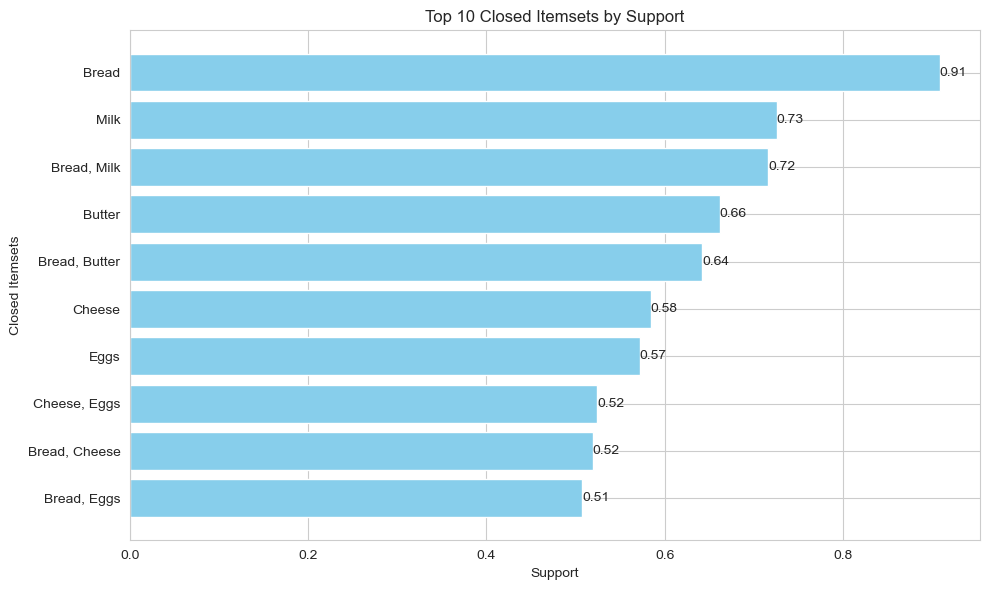

In [49]:
plot_closed_itemsets_bar(closed_itemsets, top_n=10)

### Candidate Rules from Closed Itemsets

In [51]:
def generate_rules_from_closed_itemsets(closed_df, df, min_confidence):
    transactions = df.astype(bool).values.tolist()
    n_transactions = len(transactions)

    support_dict = {
        frozenset(row['itemsets']): row['support']
        for _, row in closed_df.iterrows()
    }

    rules = []

    for itemset in support_dict:
        if len(itemset) < 2:
            continue
        for i in range(1, len(itemset)):
            for antecedent in combinations(itemset, i):
                antecedent = frozenset(antecedent)
                consequent = itemset - antecedent

                if not consequent:
                    continue

                antecedent_support = support_dict.get(antecedent, None)
                if antecedent_support is None:
                    antecedent_support = sum(all(item in row for item in antecedent) for row in transactions) / n_transactions

                itemset_support = support_dict[itemset]
                consequent_support = support_dict.get(consequent, sum(all(item in row for item in consequent) for row in transactions) / n_transactions)

                confidence = itemset_support / antecedent_support if antecedent_support > 0 else 0
                lift = confidence / consequent_support if consequent_support > 0 else 0

                if confidence >= min_confidence:
                    rules.append({
                        'antecedents': set(antecedent),
                        'consequents': set(consequent),
                        'support': itemset_support,
                        'confidence': confidence,
                        'lift': lift
                    })

    return pd.DataFrame(rules)

In [52]:
rules_from_closed = generate_rules_from_closed_itemsets(closed_itemsets, df, min_confidence=0.75)
print('Candidate Rules: ')
print(rules_from_closed)

Candidate Rules: 
        antecedents      consequents   support  confidence      lift
0            {Milk}          {Bread}  0.716463    0.987395  1.086797
1           {Bread}           {Milk}  0.716463    0.788591  1.086797
2          {Butter}          {Bread}  0.642276    0.970814  1.068547
3          {Cheese}          {Bread}  0.519309    0.888696  0.978162
4    {Cheese, Milk}          {Bread}  0.411585    0.983010  1.081970
5   {Cheese, Bread}           {Milk}  0.411585    0.792564  1.092273
6          {Cheese}           {Eggs}  0.524390    0.897391  1.568442
7            {Eggs}         {Cheese}  0.524390    0.916519  1.568442
8            {Eggs}          {Bread}  0.507114    0.886323  0.975550
9          {Cheese}    {Eggs, Bread}  0.463415    0.793043  1.563837
10           {Eggs}  {Cheese, Bread}  0.463415    0.809947  1.559663
11  {Cheese, Bread}           {Eggs}  0.463415    0.892368  1.559663
12   {Cheese, Eggs}          {Bread}  0.463415    0.883721  0.972686
13    {Eggs, Bre

This concludes the use of a few Association Rule Mining Algorithms. 